<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 11: Individual mobility</h2>
<h3>IT University of Copenhagen, Spring 2022</h3>
<h3>Instructor: Michael Szell</h3>
</div>

# Source
This notebook was adapted from:
* sci-kit mobility tutorials: https://github.com/scikit-mobility/tutorials/tree/master/mda_masterbd2020

## What is scikit-mobility?

a library to analyze <font color="blue">*mobility data*</font>, suited for working with:

- **trajectories** composed by lat/long points (e.g., GPS data)
- **fluxes** of movements between places (e.g., OD matrix)


In [3]:
# import the library
import skmob
import warnings
import geopandas as gpd
import pandas as pd
from skmob.tessellation import tilers
from skmob.utils import plot
import matplotlib.pyplot as plt
from tqdm import tqdm
from stats_utils import *

warnings.filterwarnings('ignore')
tess_style = {'color':'gray', 'fillColor':'gray', 'opacity':0.2}

scikit-mobility provides two user-friendly data structures that extends the *pandas* `DataFrame`:

- `TrajDataFrame` - for spatio-temporal <font color="blue">**trajectories**</font>
- `FlowDataFrame` - for <font color="blue">**fluxes**</font> mapped into a tessellation


### What you can do with scikit-mobility?

- **Preprocessing** of mobility data
- **Measuring** individual and collective behaviours
- <font color="grey">**Assessing** privacy risk</font>
- <font color="grey">**Predicting** migration flows</font>
- <font color="grey">**Generating** synthetic trajectories</font>
    

## `TrajDataFrame`


Each row describes a trajectory's point and contains the following columns:

- `lat` - latitude of the point
- `lng` - longitude of the point
- `datetime` - date and time of the point

For multi-user data sets, there are two *optional* columns:

- `uid` - user's identifier to which the trajectory belongs to
- `tid` - identifier for the trajectory

A `TrajDataFrame` can be created from:

- a python list or *numpy* array
- a python dictionary
- a *pandas* `DataFrame`
- a text file

### From a `list`

In [4]:
# From a list
data_list = [[1, 39.984094, 116.319236, '2008-10-23 13:53:05'],
             [1, 39.984198, 116.319322, '2008-10-23 13:53:06'],
             [1, 39.984224, 116.319402, '2008-10-23 13:53:11'],
             [1, 39.984211, 116.319389, '2008-10-23 13:53:16']]
data_list

[[1, 39.984094, 116.319236, '2008-10-23 13:53:05'],
 [1, 39.984198, 116.319322, '2008-10-23 13:53:06'],
 [1, 39.984224, 116.319402, '2008-10-23 13:53:11'],
 [1, 39.984211, 116.319389, '2008-10-23 13:53:16']]

We must set the indexes of the mandatory columns using arguments `latitude`, `longitude` and `datetime`.

In [5]:
tdf = skmob.TrajDataFrame(data_list, 
                          latitude=1, longitude=2, 
                          datetime=3)
print(type(tdf))
tdf

<class 'skmob.core.trajectorydataframe.TrajDataFrame'>


0        lat         lng            datetime
0  1  39.984094  116.319236 2008-10-23 13:53:05
1  1  39.984198  116.319322 2008-10-23 13:53:06
2  1  39.984224  116.319402 2008-10-23 13:53:11
3  1  39.984211  116.319389 2008-10-23 13:53:16

### From a `DataFrame`

In [6]:
# import the pandas library
import pandas as pd 
# build a dataframe from the 2D list
data_df = pd.DataFrame(data_list, 
                       columns=['user', 'latitude', 'lng', 'hour']) 

In [7]:
print(type(data_df)) # type of the structure
data_df.head() # head of the DataFrame

<class 'pandas.core.frame.DataFrame'>


user   latitude         lng                 hour
0     1  39.984094  116.319236  2008-10-23 13:53:05
1     1  39.984198  116.319322  2008-10-23 13:53:06
2     1  39.984224  116.319402  2008-10-23 13:53:11
3     1  39.984211  116.319389  2008-10-23 13:53:16

Note that: 
- name of columns in `data_df` don't match the names required
- you must specify the names of the mandatory columns using arguments `latitude`, `longitude` and `datetime` 

In [8]:
# Create a TrajDataFrame from a DataFrame
tdf = skmob.TrajDataFrame(data_df, 
                          latitude='latitude', 
                          datetime='hour', 
                          user_id='user')

print(type(tdf))
tdf.head()

<class 'skmob.core.trajectorydataframe.TrajDataFrame'>


uid        lat         lng            datetime
0    1  39.984094  116.319236 2008-10-23 13:53:05
1    1  39.984198  116.319322 2008-10-23 13:53:06
2    1  39.984224  116.319402 2008-10-23 13:53:11
3    1  39.984211  116.319389 2008-10-23 13:53:16

### From a text file

Class `TrajDataFrame` has a method `from_file` to construct the object from an input text file.

Let's try with a subsample of the <font color="blue">**GeoLife**</font> trajectories. The whole dataset can be found [here](https://www.microsoft.com/en-us/download/details.aspx?id=52367).

In [9]:
# create a TrajDataFrame from a dataset of trajectories 
tdf = skmob.TrajDataFrame.from_file(
    'files/geolife_sample.txt.gz', sep=',')
print(type(tdf))

<class 'skmob.core.trajectorydataframe.TrajDataFrame'>


In [10]:
# explore the TrajDataFrame
tdf.head(5)

lat         lng            datetime  uid
0  39.984094  116.319236 2008-10-23 05:53:05    1
1  39.984198  116.319322 2008-10-23 05:53:06    1
2  39.984224  116.319402 2008-10-23 05:53:11    1
3  39.984211  116.319389 2008-10-23 05:53:16    1
4  39.984217  116.319422 2008-10-23 05:53:21    1

### Attributes of a `TrajDataFrame`


- `crs`: the coordinate reference system. Default: `epsg:4326` (lat/long)
- `parameters`: dictionary to add as many as necessary additional properties

In [11]:
tdf.crs

{'init': 'epsg:4326'}

In [12]:
tdf.parameters

{'from_file': 'files/geolife_sample.txt.gz'}

In [13]:
# add your own parameter
tdf.parameters['compress'] = {'thre': 10}
tdf.parameters

{'from_file': 'files/geolife_sample.txt.gz', 'compress': {'thre': 10}}

Columns of `TrajDataFrame` have specific types

In [14]:
# In the DataFrame
print(type(data_df))
data_df.dtypes

<class 'pandas.core.frame.DataFrame'>


user          int64
latitude    float64
lng         float64
hour         object
dtype: object

In [15]:
print(type(tdf)) # In the TrajDataFrame
tdf.dtypes

<class 'skmob.core.trajectorydataframe.TrajDataFrame'>


lat                float64
lng                float64
datetime    datetime64[ns]
uid                  int64
dtype: object

In [16]:
tdf.lat.head()

0    39.984094
1    39.984198
2    39.984224
3    39.984211
4    39.984217
Name: lat, dtype: float64

### Write and read 

To write/read a `TrajDataFrame` into a file, scikit-mobility provides ad-hoc methods.

#### Writing a `TrajDataFrame` to a file

- includes the `parameters` and `crs`attributes
- preserves `dtype` of columns with timestamps (time zone info is lost though).

In [17]:
skmob.write(tdf, './tdf.json')

In [18]:
tdf.parameters

{'from_file': 'files/geolife_sample.txt.gz', 'compress': {'thre': 10}}

### Read a `TrajDataFrame` from a json file

In [19]:
# read the file written before
tdf2 = skmob.read('./tdf.json') 
tdf2[:4]

lat         lng            datetime  uid
0  39.984094  116.319236 2008-10-23 05:53:05    1
1  39.984198  116.319322 2008-10-23 05:53:06    1
2  39.984224  116.319402 2008-10-23 05:53:11    1
3  39.984211  116.319389 2008-10-23 05:53:16    1

`dtype`s and the `parameters` and `crs` attributes are preserved

In [20]:
print(tdf2.dtypes)
tdf2.parameters

lat                float64
lng                float64
datetime    datetime64[ns]
uid                  int64
dtype: object


{'from_file': 'files/geolife_sample.txt.gz', 'compress': {'thre': 10}}

### Plotting trajectories and flows

*scikit-mobility* relies on the *folium* library to plot:
- trajectories
- flows
- tessellations

In [21]:
tdf.plot_trajectory(zoom=12, weight=3, opacity=0.9, 
                    tiles='Stamen Toner', start_end_markers=True)

## `FlowDataFrame`

Each row describes a flow and contains the columns:

- `origin`: ID of the origin tile
- `destination`: ID of the destination tile
- `flow`: number of people travelling from `origin` to `destination`

<!-- NOTE: `FlowDataFrame` is a dataframe way of having Origin-Destination Matrix. -->

### Tessellation
Each `FlowDataFrame` is associated  with a <font color="blue">**tessellation**</font>, i.e., a `GeoDataFrame` that  contains two columns:
- `tile_ID`, identifier of a location
- `geometry`, geometric shape of the location

### Create of a `FlowDataFrame`

The `FlowDataFrame` can be created from:

- a python list or a numpy array
- a *pandas* `DataFrame`
- a python dictionary
- a text file


### From a file

method `from_file` creates a `FlowDataFrame` from a text file with the format:
    
- `origin`, `destination`, `flow`, `datetime` (optional)


In [22]:
tessellation = gpd.GeoDataFrame.from_file(
    "files/NY_counties_2011.geojson") # load a tessellation

# create a FlowDataFrame from a file and a tessellation
fdf = skmob.FlowDataFrame.from_file(
    "files/NY_commuting_flows_2011.csv",
    tessellation=tessellation, tile_id='tile_id', sep=",")

In [23]:
fdf.head()

flow origin destination
0  121606  36001       36001
1       5  36001       36005
2      29  36001       36007
3      11  36001       36017
4      30  36001       36019

In [24]:
fdf.dtypes

flow            int64
origin         object
destination    object
dtype: object

In [25]:
# The tessellation is an attribute of the FlowDataFrame
fdf.tessellation.head() 

tile_ID  population                                           geometry
0   36019       81716  POLYGON ((-74.00667 44.88602, -74.02739 44.995...
1   36101       99145  POLYGON ((-77.09975 42.27421, -77.09966 42.272...
2   36107       50872  POLYGON ((-76.25015 42.29668, -76.24914 42.302...
3   36059     1346176  POLYGON ((-73.70766 40.72783, -73.70027 40.739...
4   36011       79693  POLYGON ((-76.27907 42.78587, -76.27535 42.780...

### Plot the tessellation

In [26]:
fdf.plot_tessellation(popup_features=['tile_ID', 'population']) 

### Plot the flows

In [27]:
fdf.plot_flows(flow_color='green')

### Plot tessellation and flows

In [28]:
map_f = fdf.plot_tessellation(style_func_args=tess_style)
fdf[fdf['origin'] == '36061'].plot_flows(map_f=map_f, flow_exp=0., flow_popup=True)

# Mobility measures
- We load data of *checkins* made by users on **Brightkite**
- Brightkite is a location-based social network (LBSN)
- The dataset is freely available at the SNAP website: https://snap.stanford.edu/data/loc-brightkite.html

In [29]:
# load the dataset using pandas
df = pd.read_csv("files/loc-brightkite_totalCheckins.txt.gz", sep='\t', header=0, nrows=500000, 
                 names=['user', 'check-in_time', "latitude", "longitude", 
                        "location id"])

# convert the pandas DataFrame into an skmob TrajDataFrame
tdf = skmob.TrajDataFrame(df, latitude='latitude', 
            longitude='longitude', datetime='check-in_time', user_id='user')
print(tdf.shape)
tdf.head()

(500000, 5)


uid                  datetime        lat         lng  \
0    0 2010-10-16 06:02:04+00:00  39.891383 -105.070814   
1    0 2010-10-16 03:48:54+00:00  39.891077 -105.068532   
2    0 2010-10-14 18:25:51+00:00  39.750469 -104.999073   
3    0 2010-10-14 00:21:47+00:00  39.752713 -104.996337   
4    0 2010-10-13 23:31:51+00:00  39.752508 -104.996637   

                                location id  
0          7a0f88982aa015062b95e3b4843f9ca2  
1          dd7cd3d264c2d063832db506fba8bf79  
2  9848afcc62e500a01cf6fbf24b797732f8963683  
3          2ef143e12038c870038df53e0478cefc  
4          424eb3dd143292f9e013efa00486c907

In [30]:
print("number of users:\t", len(tdf.uid.unique()))
print("number of records:\t", len(tdf))

number of users:	 1231
number of records:	 500000


# Individual measures

- computed on the trajectories of a <u>single individual</u>
- quantify standard *mobility patterns*
- examples: 
    - radius of gyration
    - jump lengths
    - max distance
    - individual mobility network

## Radius of gyration $r_g$
characteristic distance traveled by an individual:

$$r_g = \sqrt{\frac{1}{N} \sum_{i=1}^N (\mathbf{r}_i - \mathbf{r}_{cm})^2}$$

$r_{cm}$ is the position vector of the *center of mass* of the set of locations visited by the individual

In [31]:
from skmob.measures.individual import radius_of_gyration

In [32]:
rg_df = radius_of_gyration(tdf)

100%|██████████████████████████████████████| 1231/1231 [00:02<00:00, 551.87it/s]


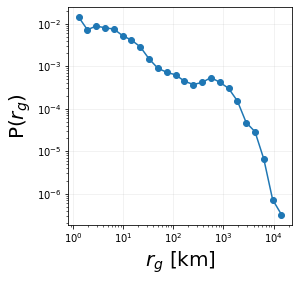

In [33]:
# let's plot the distribution of the radius of gyration
fig = plt.figure(figsize=(4, 4))
rg_list = list(rg_df.radius_of_gyration[rg_df.radius_of_gyration >= 1.0])
x, y = zip(*lbpdf(1.5, rg_list))
plt.plot(x, y, marker='o')
plt.xlabel('$r_g$ [km]', fontsize=20);plt.ylabel('P($r_g$)', fontsize=20)
plt.grid(alpha=0.2);
plt.loglog();
plt.show()

## Jump lengths
- a jump length is is the distance between two consecutive visits of an individual
- given a `TrajDataFrame`, skmob computes the lengths for each individual independently
- use the `jump_lengths` function

In [34]:
from skmob.measures.individual import jump_lengths

In [35]:
jl_df = jump_lengths(tdf) # disable progress bar with show_progress=False
jl_df.head(4)

100%|██████████████████████████████████████| 1231/1231 [00:02<00:00, 458.10it/s]


uid                                       jump_lengths
0    0  [19.64046732887831, 0.0, 0.0, 1.74343110103816...
1    1  [6.505330424378811, 46.754366003759536, 53.928...
2    2  [0.0, 0.0, 0.0, 0.0, 3.641009719594163, 0.0, 5...
3    3  [3861.270630079885, 4.061631313492122, 5.91632...

In [36]:
# merge=True put all distances of the individuals into a single list
jl_list = jump_lengths(tdf, merge=True)
type(jl_list)

100%|██████████████████████████████████████| 1231/1231 [00:02<00:00, 464.12it/s]


list

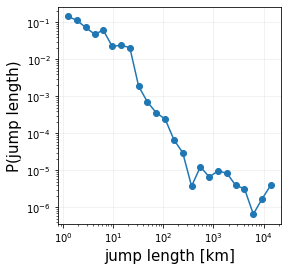

In [37]:
# let's plot the distribution of jump lengths
fig = plt.figure(figsize=(4, 4))
d_list = [dist for dist in jl_list[:10000] if dist >= 1]
x, y = zip(*lbpdf(1.5, d_list))
plt.plot(x, y, marker='o')
plt.xlabel('jump length [km]', fontsize=15);plt.ylabel('P(jump length)', fontsize=15)
plt.grid(alpha=0.2);plt.loglog();plt.show()

### Distances

- maximum distance traveled by each individual `maximum_distance`


In [38]:
from skmob.measures.individual import max_distance_from_home, distance_straight_line, maximum_distance

In [39]:
md_df = maximum_distance(tdf)
md_df.head()

100%|██████████████████████████████████████| 1231/1231 [00:02<00:00, 457.83it/s]


uid  maximum_distance
0    0      11294.436420
1    1      12804.895064
2    2      11286.745660
3    3      12803.259219
4    4      15511.927586

Text(0.5, 0, 'max')

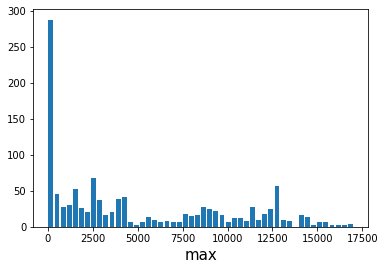

In [40]:
# let's plot the distribution
fig, ax1 = plt.subplots(1, 1)
ax1.hist(md_df.maximum_distance, bins=50, rwidth=0.8)
ax1.set_xlabel('max', fontsize=15)


## Individual mobility network
a network where: 
- nodes represent locations visited by the individual
- directed edges represent trips between the locations made by the individual 

In [41]:
from skmob.measures.individual import individual_mobility_network

In [42]:
imn_df = individual_mobility_network(tdf)
imn_df.head()

100%|██████████████████████████████████████| 1231/1231 [00:02<00:00, 419.20it/s]


uid  lat_origin  lng_origin   lat_dest    lng_dest n_trips
0    0   37.774929 -122.419415  37.600747 -122.382376       1
1    0   37.600747 -122.382376  37.615223 -122.389979       1
2    0   37.600747 -122.382376  37.580304 -122.343679       1
3    0   37.615223 -122.389979  39.878664 -104.682105       1
4    0   37.615223 -122.389979  37.580304 -122.343679       1

In [43]:
an_imn = imn_df[imn_df.uid == 2]
an_imn.sort_values(by='n_trips', ascending=False).head(5)

uid  lat_origin  lng_origin   lat_dest    lng_dest n_trips
1686    2   39.758302 -104.936129  39.802002 -105.095430      69
1452    2   39.802002 -105.095430  39.758302 -104.936129      59
1493    2   39.739154 -104.984703  39.802002 -105.095430      52
1446    2   39.802002 -105.095430  39.739154 -104.984703      51
1535    2   39.739154 -104.984703  39.818040 -105.081949      23

# Collective measures

- are computed on the trajectories of a <u>population of individuals</u>
- quantify standard *mobility patterns*
- examples: 
    - visits per time unit
    - origin destination matrix

## Visits per location

number of visits to a location made by the population of individuals

In [44]:
from skmob.measures.collective import visits_per_location

In [45]:
vpl_df = visits_per_location(tdf)
vpl_df.head()

lat         lng  n_visits
0   0.000000    0.000000     10378
1  39.739154 -104.984703      9958
2  40.014986 -105.270546      4548
3  37.774929 -122.419415      3615
4  40.714269  -74.005973      2881

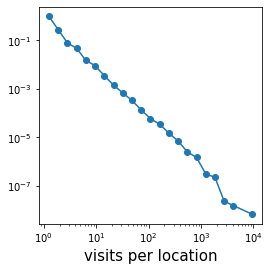

In [46]:
fig = plt.figure(figsize=(4, 4))
x, y = zip(*lbpdf(1.5, list(vpl_df.n_visits)))
plt.plot(x, y, marker='o')
plt.xlabel('visits per location', fontsize=15)
plt.loglog() 
plt.show()

### Many many other measures can be computed with scikit-mobility. 
#### Just check the documentation https://scikit-mobility.github.io/scikit-mobility/reference/measures.html